 # How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.




We create the dataset here and store it in our [data](../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings
from pprint import pprint

warnings.filterwarnings('ignore')

In [2]:
!conda list | grep pandas_datareader

In [3]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces yfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

The `crypto.h5` store can be generated using the crypto notebooks in data folder.

We load crypto minute data which is upsampled (probably hourly).

In [5]:
START = 2015
END = 2021

In [6]:
# load data from store
DATA_STORE = '../data/crypto.h5'
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['crypto/caggle/prices']).sort_index()
    cryptos = (store['coingecko/top100/market'])
    categories = store['coingecko/top100/cats']
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3261244 entries, (Timestamp('2013-04-01 00:00:00'), 'btc-usd', 'btc', 'usd') to (Timestamp('2021-05-18 07:00:00'), 'sol-usd', 'sol', 'usd')
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 156.4+ MB


In [7]:
# remove levels which are not needed
def clean_df(df):
    df = df.droplevel(['symbol', 'base'])
    return df
prices = clean_df(prices)
cryptos = clean_df(cryptos)
categories = clean_df(categories)
prices


open       high        low      close  \
date                ticker                                                 
2013-04-01 00:00:00 btc-usd    93.25000  100.00000   93.03000   93.25000   
2013-04-01 00:15:00 btc-usd    93.04399   93.35000   93.04399   93.04399   
2013-04-01 00:30:00 btc-usd    93.19999   93.35000   93.19999   93.19999   
2013-04-01 00:45:00 btc-usd    93.25000   93.30000   93.10000   93.25000   
2013-04-01 01:00:00 btc-usd    93.37999   93.48797   93.20000   93.37999   
...                                 ...        ...        ...        ...   
2021-05-18 06:45:00 sol-usd    50.50600   50.66100   50.16300   50.50600   
                    uni-usd    36.09900   36.09900   36.00000   36.09900   
2021-05-18 07:00:00 aave-usd  647.82000  647.82000  647.82000  647.82000   
                    luna-usd   15.37600   15.44800   15.37600   15.37600   
                    sol-usd    50.30400   50.30400   50.30100   50.30400   

                                   volume  
date                ticker                 
2013-04-01 00:00:00 btc-usd    247.283889  
2013-04-01 00:15:00 btc-usd     17.689501  
2013-04-01 00:30:00 btc-usd     40.000000  
2013-04-01 00:45:00 btc-usd     40.610499  
2013-04-01 01:00:00 btc-usd     23.510608  
...                                   ...  
2021-05-18 06:45:00 sol-usd   1442.344018  
                    uni-usd      1.333727  
2021-05-18 07:00:00 aave-usd     0.013275  
                    luna-usd  1829.802952  
                    sol-usd     36.807817  

[3261244 rows x 5 columns]

In [8]:
def downsample(prices, timeframe, level='ticker'):
    prices = pd.concat([prices['open'].unstack(level=level).resample(timeframe).first(),
                        prices['high'].unstack(level=level).resample(timeframe).max(),
                        prices['low'].unstack(level=level).resample(timeframe).min(),
                        prices['close'].unstack(level=level).resample(timeframe).last(),
                        prices['volume'].unstack(level=level).resample(timeframe).sum(), ],
                        keys=['open', 'high', 'low', 'close', 'volume'], axis=1).stack(level=[level], dropna=True)
    prices.dropna(inplace=True)
    return prices
timeframe='M'
prices = downsample(prices, timeframe)
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1150 entries, (Timestamp('2013-04-30 00:00:00', freq='M'), 'btc-usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xtz-usd')
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1150 non-null   float64
 1   high    1150 non-null   float64
 2   low     1150 non-null   float64
 3   close   1150 non-null   float64
 4   volume  1150 non-null   float64
dtypes: float64(5)
memory usage: 50.4+ KB


In [9]:
n_years = 3
min_obs = 12 * n_years
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs > min_obs].index
print(keep)
print(prices.info())
prices = prices.loc[(slice(None), keep), :]
print(prices.info())

prices.index.get_level_values('ticker').unique()


Index(['btc-usd', 'dai-usd', 'eos-usd', 'etc-usd', 'eth-usd', 'ltc-usd',
       'miota-usd', 'mkr-usd', 'neo-usd', 'trx-usd', 'xlm-usd', 'xmr-usd',
       'xrp-usd'],
      dtype='object', name='ticker')
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1150 entries, (Timestamp('2013-04-30 00:00:00', freq='M'), 'btc-usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xtz-usd')
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1150 non-null   float64
 1   high    1150 non-null   float64
 2   low     1150 non-null   float64
 3   close   1150 non-null   float64
 4   volume  1150 non-null   float64
dtypes: float64(5)
memory usage: 50.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 713 entries, (Timestamp('2013-04-30 00:00:00', freq='M'), 'btc-usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xrp-usd')
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  ---

Index(['btc-usd', 'ltc-usd', 'eth-usd', 'etc-usd', 'xmr-usd', 'xrp-usd',
       'miota-usd', 'eos-usd', 'neo-usd', 'trx-usd', 'dai-usd', 'mkr-usd',
       'xlm-usd'],
      dtype='object', name='ticker')

In [11]:
min_number_tickers = 10
prices = prices.unstack('ticker').dropna(thresh=min_number_tickers*5).stack('ticker')
print(prices['close'].unstack('ticker').head(3))
print(prices['close'].unstack('ticker').tail(3))

ticker      btc-usd  eos-usd  etc-usd  eth-usd  ltc-usd  miota-usd  neo-usd  \
date                                                                          
2018-02-28  10339.0   8.2074   33.200   851.67   202.68     1.8390  130.830   
2018-03-31   6928.3   5.9242   14.291   393.74   116.14     1.0716   49.915   
2018-04-30   9241.4  17.4000   21.487   668.05   148.24     1.9480   83.825   

ticker       trx-usd  xmr-usd  xrp-usd  dai-usd  mkr-usd  xlm-usd  
date                                                               
2018-02-28  0.043290   284.63  0.88264      NaN      NaN      NaN  
2018-03-31  0.033990   178.84  0.50020      NaN      NaN      NaN  
2018-04-30  0.093189   241.06  0.82831    1.002      NaN      NaN  
ticker      btc-usd   eos-usd  etc-usd  eth-usd  ltc-usd  miota-usd  neo-usd  \
date                                                                           
2021-03-31  58813.0  4.792600   14.136   1917.4   197.12     1.5303   50.865   
2021-04-30  57729.0  6.4

In [12]:
# get only shared data
shared = prices.index.get_level_values('ticker').intersection(cryptos.index.get_level_values('ticker'))\
    .intersection(categories.index.get_level_values('ticker'))
len(shared), shared

cryptos = cryptos.loc[shared, :]
categories = categories.loc[shared, :]
prices = prices.loc[(slice(None), shared), :]

assert categories.shape[0] == cryptos.shape[0]
assert prices.index.get_level_values('ticker').nunique() == categories.shape[0]
assert prices.unstack('date').shape[0] == cryptos.shape[0], categories.shape[0]
assert cryptos.shape[0] == categories.shape[0]

prices.index.get_level_values('ticker').nunique(), prices.index.get_level_values('ticker').unique()

(13,
 Index(['btc-usd', 'eos-usd', 'etc-usd', 'eth-usd', 'ltc-usd', 'miota-usd',
        'neo-usd', 'trx-usd', 'xmr-usd', 'xrp-usd', 'dai-usd', 'mkr-usd',
        'xlm-usd'],
       dtype='object', name='ticker'))

In [13]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 512 entries, (Timestamp('2018-02-28 00:00:00', freq='M'), 'btc-usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xlm-usd')
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   512 non-null    float64
 1   high    512 non-null    float64
 2   low     512 non-null    float64
 3   open    512 non-null    float64
 4   volume  512 non-null    float64
dtypes: float64(5)
memory usage: 23.8+ KB


In [14]:
prices

,,close,high,low,open,volume
date,ticker,,,,,
2018-02-28,btc-usd,10339.00000,11788.00000,6000.00000,10268.00000,1.930205e+06
2018-03-31,btc-usd,6928.30000,11700.00000,6533.00000,10314.00000,1.782415e+06
2018-04-30,btc-usd,9241.40000,9767.40000,6425.10000,6925.30000,1.278732e+06
2018-05-31,btc-usd,7466.40000,9990.00000,7040.00000,9240.60000,8.201350e+05
2018-06-30,btc-usd,6385.70000,7779.00000,5755.00000,7485.90000,7.044565e+05
...,...,...,...,...,...,...
2021-01-31,xlm-usd,0.30664,0.42000,0.12301,0.12768,5.648138e+08
2021-02-28,xlm-usd,0.40671,0.60683,0.29261,0.30754,3.201373e+08
2021-03-31,xlm-usd,0.40381,0.43876,0.34087,0.40714,8.138656e+07


In [15]:
cryptos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, btc-usd to xlm-usd
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     13 non-null     object        
 1   market_cap             13 non-null     int64         
 2   name                   13 non-null     object        
 3   sector                 13 non-null     object        
 4   genesis_date           9 non-null      datetime64[ns]
 5   market_cap_rank        13 non-null     int64         
 6   hashing_algorithm      13 non-null     object        
 7   coingecko_rank         13 non-null     int64         
 8   coingecko_score        13 non-null     float64       
 9   developer_score        13 non-null     float64       
 10  community_score        13 non-null     float64       
 11  liquidity_score        13 non-null     float64       
 12  public_interest_score  13 non-null     float64       
dtypes

In [16]:
cryptos

,id,market_cap,name,sector,genesis_date,market_cap_rank,hashing_algorithm,coingecko_rank,coingecko_score,developer_score,community_score,liquidity_score,public_interest_score
ticker,,,,,,,,,,,,,
btc-usd,bitcoin,682679851722,Bitcoin,Cryptocurrency,2009-01-03,1,SHA-256,1,80.951,104.120,68.179,99.515,0.383
eos-usd,eos,6013160638,EOS,Smart Contract Platform,2017-07-01,23,Delegated Proof-of-Stake,5,68.501,98.399,47.890,84.134,0.038
etc-usd,ethereum-classic,8534793723,Ethereum Classic,Smart Contract Platform,2015-07-30,19,Ethash,126,44.287,0.000,46.200,86.650,0.020
eth-usd,ethereum,300095281756,Ethereum,Smart Contract Platform,2015-07-30,2,Ethash,2,78.586,101.988,61.187,100.976,0.472
ltc-usd,litecoin,12049051475,Litecoin,Cryptocurrency,2011-10-08,14,Scrypt,11,64.768,77.357,51.966,84.775,0.022
miota-usd,iota,3101008354,IOTA,Internet of Things (IOT),NaT,42,Directed Acyclic Graph (DAG),204,38.059,0.000,49.143,56.050,0.042
neo-usd,neo,3793825431,NEO,Smart Contract Platform,2016-10-17,30,None,17,61.174,80.991,48.138,70.696,0.021
trx-usd,tron,5410745259,TRON,Smart Contract Platform,2017-08-28,24,Delegated Proof-of-Stake,9,65.211,88.231,49.498,79.045,0.100
xmr-usd,monero,4689844019,Monero,Privacy Coins,2014-04-18,27,RandomX,13,63.795,91.163,52.901,65.079,0.060


In [17]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, btc-usd to xlm-usd
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Analytics                           13 non-null     int64
 1   Artificial Intelligence             13 non-null     int64
 2   Asset-backed Tokens                 13 non-null     int64
 3   Automated Market Maker (AMM)        13 non-null     int64
 4   Avalanche Ecosystem                 13 non-null     int64
 5   Binance Smart Chain Ecosystem       13 non-null     int64
 6   Business Platform                   13 non-null     int64
 7   Business Services                   13 non-null     int64
 8   Centralized Exchange Token (CEX)    13 non-null     int64
 9   Communication                       13 non-null     int64
 10  Compound Tokens                     13 non-null     int64
 11  Cosmos Ecosystem                    13 non-null     int64
 12  Cryp

In [18]:
categories


,Analytics,Artificial Intelligence,Asset-backed Tokens,Automated Market Maker (AMM),Avalanche Ecosystem,Binance Smart Chain Ecosystem,Business Platform,Business Services,Centralized Exchange Token (CEX),Communication,...,Storage,Synthetic Issuer,Terra Ecosystem,Tokenized BTC,USD Stablecoin,Wrapped-Tokens,Yearn Ecosystem,Yield Aggregator,Yield Farming,xDAI Ecosystem
ticker,,,,,,,,,,,,,,,,,,,,,
btc-usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eos-usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
etc-usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eth-usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ltc-usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miota-usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
neo-usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trx-usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
xmr-usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
cryptos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, btc-usd to xlm-usd
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     13 non-null     object        
 1   market_cap             13 non-null     int64         
 2   name                   13 non-null     object        
 3   sector                 13 non-null     object        
 4   genesis_date           9 non-null      datetime64[ns]
 5   market_cap_rank        13 non-null     int64         
 6   hashing_algorithm      13 non-null     object        
 7   coingecko_rank         13 non-null     int64         
 8   coingecko_score        13 non-null     float64       
 9   developer_score        13 non-null     float64       
 10  community_score        13 non-null     float64       
 11  liquidity_score        13 non-null     float64       
 12  public_interest_score  13 non-null     float64       
dtypes

In [20]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, btc-usd to xlm-usd
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Analytics                           13 non-null     int64
 1   Artificial Intelligence             13 non-null     int64
 2   Asset-backed Tokens                 13 non-null     int64
 3   Automated Market Maker (AMM)        13 non-null     int64
 4   Avalanche Ecosystem                 13 non-null     int64
 5   Binance Smart Chain Ecosystem       13 non-null     int64
 6   Business Platform                   13 non-null     int64
 7   Business Services                   13 non-null     int64
 8   Centralized Exchange Token (CEX)    13 non-null     int64
 9   Communication                       13 non-null     int64
 10  Compound Tokens                     13 non-null     int64
 11  Cosmos Ecosystem                    13 non-null     int64
 12  Cryp

In [21]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.IndexSlice.html#prices.index.get_level_values('symbol').isin(shared)
prices.info()



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 512 entries, (Timestamp('2018-02-28 00:00:00', freq='M'), 'btc-usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xlm-usd')
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   512 non-null    float64
 1   high    512 non-null    float64
 2   low     512 non-null    float64
 3   open    512 non-null    float64
 4   volume  512 non-null    float64
dtypes: float64(5)
memory usage: 23.8+ KB


In [22]:
#prices.index.get_level_values('symbol').unique(), len(prices.index.get_level_values('symbol').unique())

In [23]:
#categories.index.unique(), len(categories.index.unique())

## Create monthly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:


# TODO create open_prices ,... and use different rules, then put back together



In [24]:
# TODO resample every other value with default mean()?



To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [25]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}{timeframe}'] = (prices['close'].groupby(level=['ticker'])
                           .pct_change(lag)
                           #.stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
#data = data.swaplevel().dropna()
data.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 512 entries, (Timestamp('2018-02-28 00:00:00', freq='M'), 'btc-usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xlm-usd')
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1M   499 non-null    float64
 1   return_2M   486 non-null    float64
 2   return_3M   473 non-null    float64
 3   return_6M   434 non-null    float64
 4   return_9M   395 non-null    float64
 5   return_12M  356 non-null    float64
dtypes: float64(6)
memory usage: 27.8+ KB


In [26]:
data.describe()

,return_1M,return_2M,return_3M,return_6M,return_9M,return_12M
count,499.000000,486.000000,473.000000,434.000000,395.000000,356.000000
mean,0.068558,0.045089,0.031271,0.017341,0.011587,0.011391
std,0.360035,0.224603,0.179529,0.126884,0.097299,0.080112
min,-0.490099,-0.329983,-0.273537,-0.228868,-0.199511,-0.141791
25%,-0.161549,-0.108694,-0.082935,-0.062020,-0.042659,-0.040286
50%,-0.003803,0.004781,0.001566,0.000440,0.000199,-0.000365
75%,0.239190,0.160653,0.120209,0.087145,0.058881,0.043963
max,1.613364,0.859101,0.616693,0.385269,0.259168,0.238765


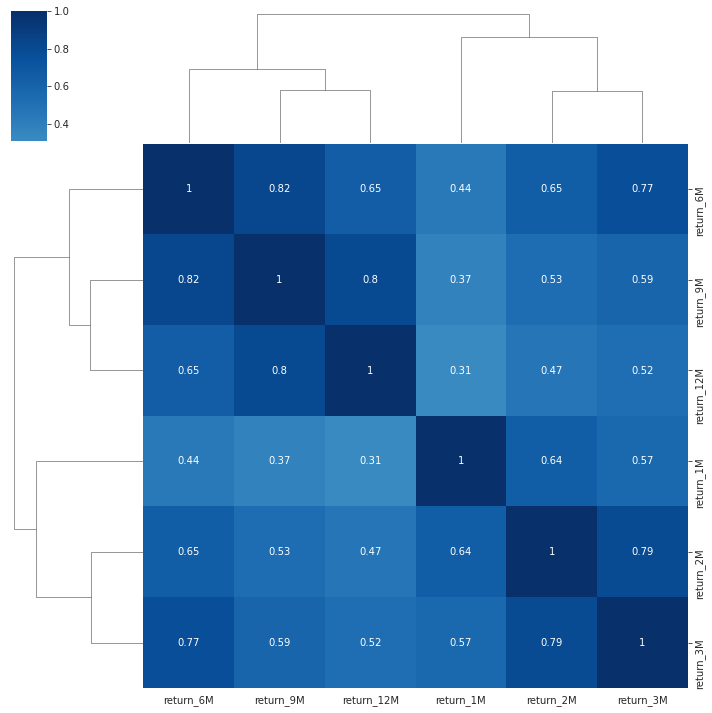

In [27]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

We are left with 1,670 tickers.

In [28]:
# data.index.get_level_values(['symbol', 'base']).nunique()
data.index.get_level_values('ticker').unique(), data.index.get_level_values('ticker').nunique(), data.index.get_level_values('ticker').nunique()

(Index(['btc-usd', 'eos-usd', 'etc-usd', 'eth-usd', 'ltc-usd', 'miota-usd',
        'neo-usd', 'trx-usd', 'xmr-usd', 'xrp-usd', 'dai-usd', 'mkr-usd',
        'xlm-usd'],
       dtype='object', name='ticker'),
 13,
 13)

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 9, Time Series Models](../09_time_series_models).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `RollingOLS` rolling linear regression functionality in the `statsmodels` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [29]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample(timeframe).last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2015-01-31 to 2021-04-30
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  76 non-null     float64
 1   SMB     76 non-null     float64
 2   HML     76 non-null     float64
 3   RMW     76 non-null     float64
 4   CMA     76 non-null     float64
dtypes: float64(5)
memory usage: 3.6 KB


In [30]:
factor_data = factor_data.join(data[f'return_1{timeframe}']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 499 entries, (Timestamp('2018-02-28 00:00:00', freq='M'), 'btc-usd') to (Timestamp('2021-04-30 00:00:00', freq='M'), 'xrp-usd')
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     499 non-null    float64
 1   SMB        499 non-null    float64
 2   HML        499 non-null    float64
 3   RMW        499 non-null    float64
 4   CMA        499 non-null    float64
 5   return_1M  486 non-null    float64
dtypes: float64(6)
memory usage: 28.5+ KB


In [31]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1M
count,499.000000,499.000000,499.000000,499.000000,499.000000,486.000000
mean,0.013318,0.001705,-0.009266,0.001302,-0.001852,0.065866
std,0.054968,0.032346,0.038530,0.018291,0.018702,0.357197
min,-0.133800,-0.083800,-0.139600,-0.033300,-0.032800,-0.490099
25%,-0.001100,-0.019500,-0.027100,-0.011500,-0.014700,-0.163924
50%,0.020600,0.002400,-0.013900,0.000900,-0.003800,-0.003836
75%,0.039600,0.019400,0.005700,0.008600,0.010600,0.237346
max,0.136500,0.068800,0.074000,0.064300,0.046800,1.613364


In [32]:
factor_data.head(10)

Mkt-RF     SMB     HML     RMW     CMA  return_1M
date       ticker                                                      
2018-02-28 btc-usd   -0.0365  0.0037 -0.0101  0.0058 -0.0223        NaN
           eos-usd   -0.0365  0.0037 -0.0101  0.0058 -0.0223        NaN
           etc-usd   -0.0365  0.0037 -0.0101  0.0058 -0.0223        NaN
           eth-usd   -0.0365  0.0037 -0.0101  0.0058 -0.0223        NaN
           ltc-usd   -0.0365  0.0037 -0.0101  0.0058 -0.0223        NaN
           miota-usd -0.0365  0.0037 -0.0101  0.0058 -0.0223        NaN
           neo-usd   -0.0365  0.0037 -0.0101  0.0058 -0.0223        NaN
           trx-usd   -0.0365  0.0037 -0.0101  0.0058 -0.0223        NaN
           xmr-usd   -0.0365  0.0037 -0.0101  0.0058 -0.0223        NaN
           xrp-usd   -0.0365  0.0037 -0.0101  0.0058 -0.0223        NaN

In [33]:
# average over T months
T = 12
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x[f'return_1{timeframe}'],
                                     exog=sm.add_constant(x.drop(f'return_1{timeframe}', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [34]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,356.000000,356.000000,356.000000,356.000000,356.000000,499.000000
mean,0.254190,-0.505509,-0.080164,2.707070,-1.422111,0.680235
std,3.588520,8.227540,4.118402,13.837630,7.211482,14.970709
min,-10.825841,-23.378213,-16.211101,-42.087921,-21.367681,-43.381762
25%,-2.401794,-6.285718,-2.800964,-4.350751,-6.532094,-5.878560
50%,0.490303,-1.406738,0.135605,0.808008,-1.545636,0.000000
75%,2.716340,4.247967,2.942195,9.755063,2.478973,3.812290
max,9.049488,23.769153,11.729915,45.888405,28.839642,65.698705


In [35]:
betas.unstack('ticker')

Mkt-RF                                                     \
ticker       btc-usd    eos-usd   etc-usd   eth-usd   ltc-usd miota-usd   
date                                                                      
2018-02-28       NaN        NaN       NaN       NaN       NaN       NaN   
2018-03-31       NaN        NaN       NaN       NaN       NaN       NaN   
2018-04-30       NaN        NaN       NaN       NaN       NaN       NaN   
2018-05-31       NaN        NaN       NaN       NaN       NaN       NaN   
2018-06-30       NaN        NaN       NaN       NaN       NaN       NaN   
2018-07-31       NaN        NaN       NaN       NaN       NaN       NaN   
2018-08-31       NaN        NaN       NaN       NaN       NaN       NaN   
2018-09-30       NaN        NaN       NaN       NaN       NaN       NaN   
2018-10-31       NaN        NaN       NaN       NaN       NaN       NaN   
2018-11-30       NaN        NaN       NaN       NaN       NaN       NaN   
2018-12-31       NaN        NaN       NaN       NaN       NaN       NaN   
2019-01-31  1.996324   3.792453  1.658748  1.109007  2.395148  0.359449   
2019-02-28  1.987970   3.763267  1.648953  1.089940  2.374032  0.344821   
2019-03-31  1.324622   4.740080  0.481155 -0.456845  2.220473 -0.111282   
2019-04-30 -0.893936  -0.900756 -3.218200 -3.768138  0.259895 -3.101374   
2019-05-31 -2.244974  -2.929149 -4.309853 -5.081407 -1.192073 -4.338849   
2019-06-30 -4.066958  -6.587685 -5.390192 -7.071584 -3.882074 -6.683045   
2019-07-31 -3.236538  -5.868443 -4.805774 -6.279376 -3.284676 -6.338968   
2019-08-31 -3.413413  -6.246148 -5.132238 -6.789134 -3.847035 -6.744052   
2019-09-30 -2.440600  -5.805727 -4.879155 -6.112617 -3.392349 -6.507568   
2019-10-31 -2.422563  -5.798201 -4.787646 -5.902038 -3.226563 -6.368157   
2019-11-30 -1.807737  -5.109708 -3.870582 -5.002074 -2.888860 -5.633700   
2019-12-31 -4.787444 -10.825841 -6.141168 -6.816665 -5.244183 -8.059729   
2020-01-31 -3.809982  -8.787124 -2.440781 -4.730808 -3.232148 -5.575034   
2020-02-29 -0.376062  -1.256458  3.231000 -2.602516  0.579663 -0.252037   
2020-03-31 -0.073300  -1.088854  3.843501 -2.394762  0.653146  0.146422   
2020-04-30  0.410011   0.466520  4.511598 -1.405284  1.550914  0.914630   
2020-05-31  2.044893   2.461683  6.449055  0.438420  3.174807  2.486134   
2020-06-30  1.797008   3.224874  7.211573  0.499451  3.207679  3.248583   
2020-07-31  2.306913   3.830785  6.335069  2.527676  4.222557  3.723973   
2020-08-31  2.692300   3.650923  6.821811  2.395540  3.773583  3.712527   
2020-09-30  2.654917   3.940622  7.651038  2.927896  4.208411  5.253297   
2020-10-31  1.256584   2.933683  5.672044  2.098512  2.255442  3.682354   
2020-11-30  2.655376   4.398183  7.421201  4.457890  4.663550  5.838162   
2020-12-31  2.553537   4.228245  7.482934  4.172963  4.473938  5.590541   
2021-01-31  2.252791   2.291093  2.554579  2.357227  3.625125  2.489310   
2021-02-28  2.120710   2.556509  2.290743  3.325771  3.686416  1.568116   
2021-03-31  2.366919   2.963620  2.716017  3.518614  3.998869  3.762398   
2021-04-30  2.025434   2.946777  3.963909  3.679461  4.591228  4.035214   

                                                    ...        CMA             \
ticker       neo-usd   trx-usd   xmr-usd   xrp-usd  ...    eth-usd    ltc-usd   
date                                                ...                         
2018-02-28       NaN       NaN       NaN       NaN  ...        NaN        NaN   
2018-03-31       NaN       NaN       NaN       NaN  ...        NaN        NaN   
2018-04-30       NaN       NaN       NaN       NaN  ...        NaN        NaN   
2018-05-31       NaN       NaN       NaN       NaN  ...        NaN        NaN   
2018-06-30       NaN       NaN       NaN       NaN  ...        NaN        NaN   
2018-07-31       NaN       NaN       NaN       NaN  ...        NaN        NaN   
2018-08-31       NaN       NaN       NaN       NaN  ...        NaN        NaN   
2018-09-30       NaN       NaN       NaN       NaN  .

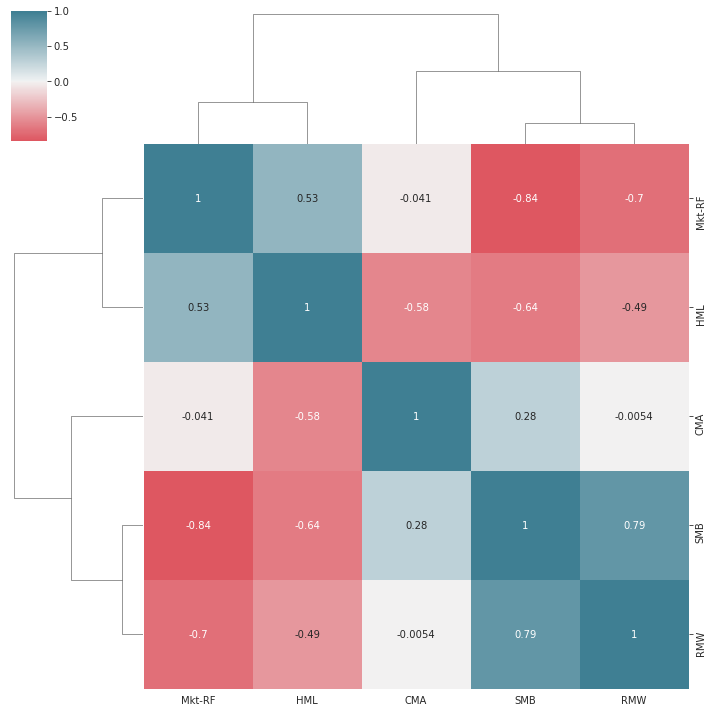

In [36]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [37]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 512 entries, (Timestamp('2018-02-28 00:00:00', freq='M'), 'btc-usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xlm-usd')
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1M   499 non-null    float64
 1   return_2M   486 non-null    float64
 2   return_3M   473 non-null    float64
 3   return_6M   434 non-null    float64
 4   return_9M   395 non-null    float64
 5   return_12M  356 non-null    float64
 6   Mkt-RF      343 non-null    float64
 7   SMB         343 non-null    float64
 8   HML         343 non-null    float64
 9   RMW         343 non-null    float64
 10  CMA         343 non-null    float64
dtypes: float64(11)
memory usage: 64.0+ KB


### Impute mean for missing factor betas

In [38]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 512 entries, (Timestamp('2018-02-28 00:00:00', freq='M'), 'btc-usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xlm-usd')
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1M   499 non-null    float64
 1   return_2M   486 non-null    float64
 2   return_3M   473 non-null    float64
 3   return_6M   434 non-null    float64
 4   return_9M   395 non-null    float64
 5   return_12M  356 non-null    float64
 6   Mkt-RF      512 non-null    float64
 7   SMB         512 non-null    float64
 8   HML         512 non-null    float64
 9   RMW         512 non-null    float64
 10  CMA         512 non-null    float64
dtypes: float64(11)
memory usage: 64.0+ KB


## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [39]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}{timeframe}'].sub(data[f'return_1{timeframe}'])
data[f'momentum_3_12'] = data[f'return_12{timeframe}'].sub(data[f'return_3{timeframe}'])

## Date Indicators

In [40]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [41]:
for t in range(1, 7):
    data[f'return_1{timeframe}_t-{t}'] = data.groupby(level='ticker')[f'return_1{timeframe}'].shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 512 entries, (Timestamp('2018-02-28 00:00:00', freq='M'), 'btc-usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xlm-usd')
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1M      499 non-null    float64
 1   return_2M      486 non-null    float64
 2   return_3M      473 non-null    float64
 3   return_6M      434 non-null    float64
 4   return_9M      395 non-null    float64
 5   return_12M     356 non-null    float64
 6   Mkt-RF         512 non-null    float64
 7   SMB            512 non-null    float64
 8   HML            512 non-null    float64
 9   RMW            512 non-null    float64
 10  CMA            512 non-null    float64
 11  momentum_2     486 non-null    float64
 12  momentum_3     473 non-null    float64
 13  momentum_6     434 non-null    float64
 14  momentum_9     395 non-null    float64
 15  momentum_12    356 non-null    float

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [42]:
for t in [1,2,3,6,12]:
    data[f'target_{t}{timeframe}'] = data.groupby(level='ticker')[f'return_{t}{timeframe}'].shift(-t)

In [43]:
data.columns.values.tolist(), timeframe

(['return_1M',
  'return_2M',
  'return_3M',
  'return_6M',
  'return_9M',
  'return_12M',
  'Mkt-RF',
  'SMB',
  'HML',
  'RMW',
  'CMA',
  'momentum_2',
  'momentum_3',
  'momentum_6',
  'momentum_9',
  'momentum_12',
  'momentum_3_12',
  'year',
  'month',
  'return_1M_t-1',
  'return_1M_t-2',
  'return_1M_t-3',
  'return_1M_t-4',
  'return_1M_t-5',
  'return_1M_t-6',
  'target_1M',
  'target_2M',
  'target_3M',
  'target_6M',
  'target_12M'],
 'M')

In [44]:
cols = [f'target_1{timeframe}',
        f'target_2{timeframe}',
        f'target_3{timeframe}',
        f'return_1{timeframe}',
        f'return_2{timeframe}',
        f'return_3{timeframe}',
        f'return_1{timeframe}_t-1',
        f'return_1{timeframe}_t-2',
        f'return_1{timeframe}_t-3']

data[cols].dropna().sort_index().head(10)

target_1M  target_2M  target_3M  return_1M  return_2M  \
date       ticker                                                             
2018-06-30 btc-usd     0.214839   0.047990   0.012094  -0.144742  -0.168743   
           eos-usd    -0.092619  -0.110367  -0.110029  -0.335248  -0.317628   
           etc-usd     0.000000  -0.113383  -0.111942   0.061517  -0.131620   
           eth-usd    -0.043006  -0.211099  -0.198874  -0.212125  -0.176991   
           ltc-usd    -0.025458  -0.126290  -0.089751  -0.311688  -0.260110   
           miota-usd  -0.060959  -0.162761  -0.174367  -0.419366  -0.279588   
           neo-usd    -0.030319  -0.191981  -0.149283  -0.419781  -0.329983   
           trx-usd    -0.115707  -0.185075  -0.165495  -0.364478  -0.329983   
           xmr-usd    -0.062977  -0.060169  -0.040415  -0.158746  -0.262821   
           xrp-usd    -0.065921  -0.152106   0.077108  -0.235940  -0.250173   

                      return_3M  return_1M_t-1  return_1M_t-2  return_1M_t-3  
date       ticker                                                             
2018-06-30 btc-usd    -0.026818      -0.192070       0.333863      -0.329887  
           eos-usd     0.109995      -0.299540       1.613364      -0.278188  
           etc-usd     0.042744      -0.289617       0.503534      -0.490099  
           eth-usd     0.047457      -0.140289       0.696678      -0.490099  
           ltc-usd    -0.112628      -0.204668       0.276391      -0.426978  
           miota-usd  -0.019217      -0.106160       0.817842      -0.417292  
           neo-usd    -0.149206      -0.367969       0.679355      -0.490099  
           trx-usd     0.039926      -0.354548       1.613364      -0.214830  
           xmr-usd    -0.098563      -0.354020       0.347909      -0.371676  
           xrp-usd    -0.023534      -0.264140       0.655958      -0.433291

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 512 entries, (Timestamp('2018-02-28 00:00:00', freq='M'), 'btc-usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xlm-usd')
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1M      499 non-null    float64
 1   return_2M      486 non-null    float64
 2   return_3M      473 non-null    float64
 3   return_6M      434 non-null    float64
 4   return_9M      395 non-null    float64
 5   return_12M     356 non-null    float64
 6   Mkt-RF         512 non-null    float64
 7   SMB            512 non-null    float64
 8   HML            512 non-null    float64
 9   RMW            512 non-null    float64
 10  CMA            512 non-null    float64
 11  momentum_2     486 non-null    float64
 12  momentum_3     473 non-null    float64
 13  momentum_6     434 non-null    float64
 14  momentum_9     395 non-null    float64
 15  momentum_12    356 non-null    float

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [46]:
age_quintiles = pd.qcut(cryptos['genesis_date'], q=5, labels=list(range(1, 6))).astype(float).fillna(0).astype(int).to_frame('age')
age_quintiles

,age
ticker,
btc-usd,1
eos-usd,4
etc-usd,2
eth-usd,2
ltc-usd,1
miota-usd,0
neo-usd,4
trx-usd,5
xmr-usd,2


In [47]:
data = data.join(age_quintiles)
# data.age = data.age.fillna(-1)

In [48]:
data['age'].unstack('ticker')

ticker,btc-usd,eos-usd,etc-usd,eth-usd,ltc-usd,miota-usd,neo-usd,trx-usd,xmr-usd,xrp-usd,dai-usd,mkr-usd,xlm-usd
date,,,,,,,,,,,,,
2018-02-28,1.0,4.0,2.0,2.0,1.0,0.0,4.0,5.0,2.0,0.0,NaN,NaN,NaN
2018-03-31,1.0,4.0,2.0,2.0,1.0,0.0,4.0,5.0,2.0,0.0,NaN,NaN,NaN
2018-04-30,1.0,4.0,2.0,2.0,1.0,0.0,4.0,5.0,2.0,0.0,0.0,NaN,NaN
2018-05-31,1.0,4.0,2.0,2.0,1.0,0.0,4.0,5.0,2.0,0.0,0.0,5.0,0.0
2018-06-30,1.0,4.0,2.0,2.0,1.0,0.0,4.0,5.0,2.0,0.0,0.0,5.0,0.0
2018-07-31,1.0,4.0,2.0,2.0,1.0,0.0,4.0,5.0,2.0,0.0,0.0,5.0,0.0
2018-08-31,1.0,4.0,2.0,2.0,1.0,0.0,4.0,5.0,2.0,0.0,0.0,5.0,0.0
2018-09-30,1.0,4.0,2.0,2.0,1.0,0.0,4.0,5.0,2.0,0.0,0.0,5.0,0.0
2018-10-31,1.0,4.0,2.0,2.0,1.0,0.0,4.0,5.0,2.0,0.0,0.0,5.0,0.0


## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [49]:
cryptos.info()



<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, btc-usd to xlm-usd
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     13 non-null     object        
 1   market_cap             13 non-null     int64         
 2   name                   13 non-null     object        
 3   sector                 13 non-null     object        
 4   genesis_date           9 non-null      datetime64[ns]
 5   market_cap_rank        13 non-null     int64         
 6   hashing_algorithm      13 non-null     object        
 7   coingecko_rank         13 non-null     int64         
 8   coingecko_score        13 non-null     float64       
 9   developer_score        13 non-null     float64       
 10  community_score        13 non-null     float64       
 11  liquidity_score        13 non-null     float64       
 12  public_interest_score  13 non-null     float64       
dtypes

Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [50]:
prices.close.unstack(level='ticker').tail(2)

ticker,btc-usd,eos-usd,etc-usd,eth-usd,ltc-usd,miota-usd,neo-usd,trx-usd,xmr-usd,xrp-usd,dai-usd,mkr-usd,xlm-usd
date,,,,,,,,,,,,,
2021-04-30,57729.0,6.443056,36.374,2766.3,271.11,2.1190,97.146,0.13248,420.53,1.5931,0.9991,4348.0,0.52887
2021-05-31,45367.0,9.693300,92.560,3521.9,305.55,1.9726,90.940,0.11851,355.45,1.5415,1.0000,4863.4,0.67204


In [51]:
prices_unstacked = prices.close.unstack(level='ticker')

In [52]:
prices_unstacked.iloc[-1]


ticker
btc-usd      45367.00000
eos-usd          9.69330
etc-usd         92.56000
eth-usd       3521.90000
ltc-usd        305.55000
miota-usd        1.97260
neo-usd         90.94000
trx-usd          0.11851
xmr-usd        355.45000
xrp-usd          1.54150
dai-usd          1.00000
mkr-usd       4863.40000
xlm-usd          0.67204
Name: 2021-05-31 00:00:00, dtype: float64

In [53]:
market_cap = prices_unstacked/prices_unstacked.iloc[-1]*cryptos['market_cap']
# market_cap = market_cap.stack([0,1])
market_cap

ticker,btc-usd,eos-usd,etc-usd,eth-usd,ltc-usd,miota-usd,neo-usd,trx-usd,xmr-usd,xrp-usd,dai-usd,mkr-usd,xlm-usd
date,,,,,,,,,,,,,
2018-02-28,1.555806e+11,5.091395e+09,3.061313e+09,7.256939e+10,7.992478e+09,2.890984e+09,5.457952e+09,1.976467e+09,3.755438e+09,2.666027e+10,NaN,NaN,NaN
2018-03-31,1.042566e+11,3.675030e+09,1.317748e+09,3.354994e+10,4.579862e+09,1.684599e+09,2.082349e+09,1.551863e+09,2.359633e+09,1.510861e+10,NaN,NaN,NaN
2018-04-30,1.390640e+11,1.079395e+10,1.981278e+09,5.692344e+10,5.845693e+09,3.062336e+09,3.497003e+09,4.254678e+09,3.180571e+09,2.501922e+10,4.440170e+09,NaN,NaN
2018-05-31,1.123539e+11,7.560728e+09,1.407466e+09,4.893771e+10,4.649266e+09,2.737238e+09,2.210214e+09,2.746189e+09,2.054586e+09,1.841064e+10,4.404720e+09,4.879553e+08,4.333250e+09
2018-06-30,9.609162e+10,5.026010e+09,1.494050e+09,3.855678e+10,3.200146e+09,1.589334e+09,1.282408e+09,1.745263e+09,1.728428e+09,1.406684e+10,4.387970e+09,3.569937e+08,2.840195e+09
2018-07-31,1.167359e+11,4.560506e+09,1.494050e+09,3.689862e+10,3.118675e+09,1.492449e+09,1.243527e+09,1.543325e+09,1.619576e+09,1.313954e+10,4.417571e+09,3.994559e+08,4.126905e+09
2018-08-31,1.055357e+11,3.977819e+09,1.174456e+09,2.399638e+10,2.442895e+09,1.114074e+09,8.372782e+08,1.159035e+09,1.526690e+09,1.011298e+10,4.426921e+09,2.995919e+08,3.260255e+09
2018-09-30,9.962037e+10,3.542835e+09,1.046379e+09,1.982457e+10,2.413517e+09,8.944914e+08,7.895529e+08,1.014258e+09,1.527217e+09,1.757818e+10,4.439727e+09,3.082268e+08,3.837432e+09
2018-10-31,9.586991e+10,3.257416e+09,8.360428e+08,1.694794e+10,1.969412e+09,7.385449e+08,6.446249e+08,1.022248e+09,1.382346e+09,1.370921e+10,4.462327e+09,4.379035e+08,3.337781e+09


### Create Size indicator as deciles per period

Compute size deciles per month:

In [54]:
market_cap_deciles = market_cap.dropna(axis=0, thresh=2).apply(lambda x: pd.qcut(x, q=5, labels=list(range(1, 6))), axis=1, )
market_cap_deciles

,btc-usd,eos-usd,etc-usd,eth-usd,ltc-usd,miota-usd,neo-usd,trx-usd,xmr-usd,xrp-usd,dai-usd,mkr-usd,xlm-usd
date,,,,,,,,,,,,,
2018-02-28,5,3,2,5,4,1,3,1,2,4,NaN,NaN,NaN
2018-03-31,5,3,1,5,4,2,2,1,3,4,NaN,NaN,NaN
2018-04-30,5,4,1,5,3,1,2,2,1,4,3,NaN,NaN
2018-05-31,5,4,1,5,4,2,2,3,1,5,3,1,3
2018-06-30,5,4,1,5,3,2,1,3,2,5,4,1,3
2018-07-31,5,4,2,5,3,1,1,2,3,5,4,1,3
2018-08-31,5,4,2,5,3,1,1,2,3,5,4,1,3
2018-09-30,5,3,2,5,3,1,1,2,3,5,4,1,4
2018-10-31,5,3,2,5,3,1,1,2,3,5,4,1,4


In [55]:
market_cap_deciles = market_cap_deciles.stack(0)
market_cap_deciles

date               
2018-02-28  btc-usd    5
            eos-usd    3
            etc-usd    2
            eth-usd    5
            ltc-usd    4
                      ..
2021-05-31  xmr-usd    2
            xrp-usd    5
            dai-usd    2
            mkr-usd    1
            xlm-usd    4
Length: 512, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [56]:
market_cap_deciles.index.set_names(['date', 'ticker'], inplace=True)
market_cap_deciles.rename('msize', inplace=True)
market_cap_deciles

date        ticker 
2018-02-28  btc-usd    5
            eos-usd    3
            etc-usd    2
            eth-usd    5
            ltc-usd    4
                      ..
2021-05-31  xmr-usd    2
            xrp-usd    5
            dai-usd    2
            mkr-usd    1
            xlm-usd    4
Name: msize, Length: 512, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [57]:
data = data.join(market_cap_deciles)

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 512 entries, (Timestamp('2018-02-28 00:00:00', freq='M'), 'btc-usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xlm-usd')
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   return_1M      499 non-null    float64 
 1   return_2M      486 non-null    float64 
 2   return_3M      473 non-null    float64 
 3   return_6M      434 non-null    float64 
 4   return_9M      395 non-null    float64 
 5   return_12M     356 non-null    float64 
 6   Mkt-RF         512 non-null    float64 
 7   SMB            512 non-null    float64 
 8   HML            512 non-null    float64 
 9   RMW            512 non-null    float64 
 10  CMA            512 non-null    float64 
 11  momentum_2     486 non-null    float64 
 12  momentum_3     473 non-null    float64 
 13  momentum_6     434 non-null    float64 
 14  momentum_9     395 non-null    float64 
 15  momentum_12    356 

In [59]:
data.tail()

,,return_1M,return_2M,return_3M,return_6M,return_9M,return_12M,Mkt-RF,SMB,HML,RMW,...,return_1M_t-4,return_1M_t-5,return_1M_t-6,target_1M,target_2M,target_3M,target_6M,target_12M,age,msize
date,ticker,,,,,,,,,,,,,,,,,,,,,
2021-01-31,xlm-usd,1.400125,0.230011,0.580741,0.211592,0.180931,0.144061,6.853821,-6.910414,3.743477,-14.450628,...,-0.235567,0.008181,0.446901,0.326344,0.147557,0.199242,NaN,NaN,0,4
2021-02-28,xlm-usd,0.326344,0.784206,0.261318,0.268263,0.214532,0.177706,4.759782,-0.696369,1.936344,-8.407229,...,0.039152,-0.235567,0.008181,-0.007130,0.140334,0.182234,NaN,NaN,0,4
2021-03-31,xlm-usd,-0.007130,0.147557,0.467554,0.324753,0.220902,0.210209,5.452983,-1.684484,2.975545,-6.809810,...,1.610745,0.039152,-0.235567,0.309700,0.290057,NaN,NaN,NaN,0,4
2021-04-30,xlm-usd,0.309700,0.140334,0.199242,0.376841,0.207461,0.185482,7.425062,0.244599,3.898213,-11.145528,...,-0.369647,1.610745,0.039152,0.270709,NaN,NaN,NaN,NaN,0,4
2021-05-31,xlm-usd,0.270709,0.290057,0.182234,0.221136,0.238913,0.206376,2.250989,-1.590903,-1.302554,2.893605,...,1.400125,-0.369647,1.610745,NaN,NaN,NaN,NaN,NaN,0,4


## Store data

We will use the data again in several later chapters, starting in [Chapter 7 on Linear Models](../07_linear_models).

In [60]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index(), format='t')
    print(store.info())




<class 'pandas.io.pytables.HDFStore'>
File path: ../data/crypto.h5
/coingecko/top100/cats                                   frame        (shape->[100,50])                                                               
/coingecko/top100/market                                 frame        (shape->[100,13])                                                               
/crypto/caggle/prices                                    frame        (shape->[3261244,5])                                                            
/engineered_features                                     frame_table  (typ->appendable_multi,nrows->512,ncols->34,indexers->[index],dc->[ticker,date])
/engineered_features/meta/values_block_2/meta            series_table (typ->appendable,nrows->5,ncols->1,indexers->[index],dc->[values])              
